# Demonstration: 2-Scenario Bilinear Stochastic Program 

Using this simple test problem, we can demonstrate the progression of the SNoGloDe solver.

In [1]:
import pyomo.environ as pyo
import matplotlib.pyplot as plt
import numpy as np

Consider the case of a bilinear optimization problem. 

$$
    \text{min.}_{x,y} - x - y
$$
$$
    \text{s.t.}    x y \leq c
$$
$$
    \text{x}^{L} \leq x \leq \text{x}^{U}
$$
$$
    \text{y}^{L} \leq y \leq \text{y}^{U}
$$
$$
    x \in \mathbb{R}^1 , y \in \mathbb{R}^1
$$

This is a nonconvex, continuous optimization problem. Here, $x$ and $y$ are continuous optimization variables. The constant $c$ influences the bilinear constraint. $\text{x}^{L}$ and $\text{x}^{U}$ are the parameterized upper and lower bound on $x$ and $\text{y}^{L}$ and $\text{y}^{U}$ are the parameterized upper and lower bound on $y$.

Depending on the parameters chosen, we can develop different instances of this optimization problem. For this demonstration, we will consider two instances that will act as "scenarios" within a 2-stage stochastic program. We want to solve these two "scenarios" such that the $x$ variables are equivalent, while the $y$ variables can different.

In [2]:
class NonconvexOpt():
    def __init__(self, b1=4, y_ub=6, y_lb=0, x_ub=4, x_lb=0) -> None:
        self.b1 = b1
        self.y_ub = y_ub
        self.y_lb = y_lb
        self.x_ub = x_ub
        self.x_lb = x_lb
        self.build_bilinear_model()

    def build_bilinear_model(self):
        m = pyo.ConcreteModel()
        m.x = pyo.Var(within=pyo.Reals,
                      bounds=(self.x_lb,self.x_ub))      
        m.y = pyo.Var(within=pyo.Reals,
                      bounds=(self.y_lb,self.y_ub))
        m.obj = pyo.Objective( expr = ( - m.x - m.y ) )
        @m.Constraint()
        def c1_rule(m):
            return (m.x * m.y <= self.b1)
        self.m=m

    def solve(self):
        # solve model
        opt = pyo.SolverFactory("gurobi")
        opt.options["NonConvex"] = 2
        opt.solve(self.m, tee=False)
        # save optimal results to object
        self.x_opt = pyo.value(self.m.x)
        self.y_opt = pyo.value(self.m.y)
        self.obj_opt = pyo.value(self.m.obj)
        
    def plot(self, title, opt_x, opt_y):
        # plot the feasible region
        d = np.linspace(-10,10,300)
        x,y = np.meshgrid(d,d)
        plt.imshow( ((y>=self.y_lb) & (y <= self.y_ub) & (x>=self.x_lb) & (x<=self.x_ub) & \
                     (y*x <= self.b1) ).astype(int) , 
                        extent=(x.min(),x.max(),y.min(),y.max()),
                        origin="lower", cmap="Greys", alpha = 0.2);
        # plot the lines defining the constraints
        x = np.linspace(-1, 7, 2000)
        # y >= 0
        y1 = 0*x + self.y_lb
        # y <= 4
        y2 = 0*x + self.y_ub
        # y <= 4/x
        y3 = self.b1 / x
        # Make plot
        plt.scatter(opt_x, opt_y, marker="*", color = "gold", s=200, zorder=100, label="optimal")
        plt.plot(x, y3, label=f'$yx\leq {self.b1}$', color="blue")
        plt.plot(x, y1, label=f'$y\geq {self.y_lb}$', color="black")
        plt.plot(x, y2, label=f'$y\leq {self.y_ub}$', color="grey")
        # bounds on x var
        plt.plot(np.linspace(self.x_lb,self.x_lb,2000), x, label=f'$x\geq {self.x_lb}$')
        plt.plot(np.linspace(self.x_ub,self.x_ub,2000), x, label=f'$x\leq {self.x_ub}$', color = "teal")
        plt.xlim(-1,7)
        plt.ylim(-1,7)
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.xlabel(r'$x$')
        plt.ylabel(r'$y$')
        plt.title(title)
        plt.grid()
        plt.show()

### Scenario (1)

The first scenario has $c$ = 4, $\text{x}^{L}$ = 0, $\text{x}^{U}$ = 6, $\text{y}^{L}$ = 0, and $\text{y}^{U}$ = 4.

See below for the optimal solution to the deterministic model, along with a plot of the feasible space and optimal solution.

OPTIMAL SOLUTION:
	obj = -6.667
	x = 6.0
	y = 0.667


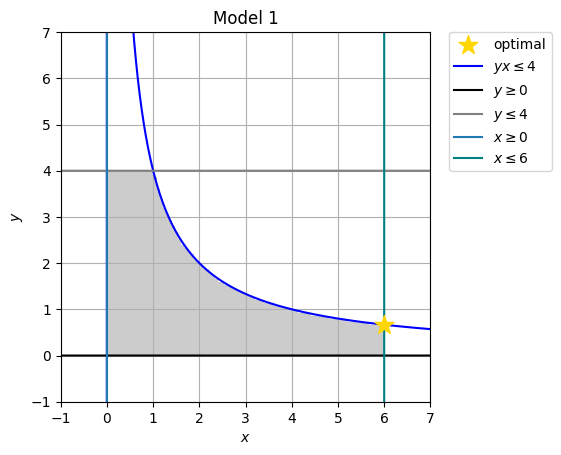

In [3]:
model1 = NonconvexOpt(b1=4,
                      y_lb=0,
                      y_ub=4,
                      x_lb=0,
                      x_ub=6)
model1.solve()
print(f"OPTIMAL SOLUTION:\n\tobj = {round(model1.obj_opt,3)}\n\tx = {round(model1.x_opt,3)}\n\ty = {round(model1.y_opt,3)}")
model1.plot("Model 1", opt_x=model1.x_opt, opt_y=model1.y_opt)

### Scenario (2)

The first scenario has $c$ = 8, $\text{x}^{L}$ = 0, $\text{x}^{U}$ = 4, $\text{y}^{L}$ = 0, and $\text{y}^{U}$ = 6.

See below for the optimal solution to the deterministic model, along with a plot of the feasible space and optimal solution.

OPTIMAL SOLUTION:
	obj = -7.333
	x = 1.333
	y = 6.0


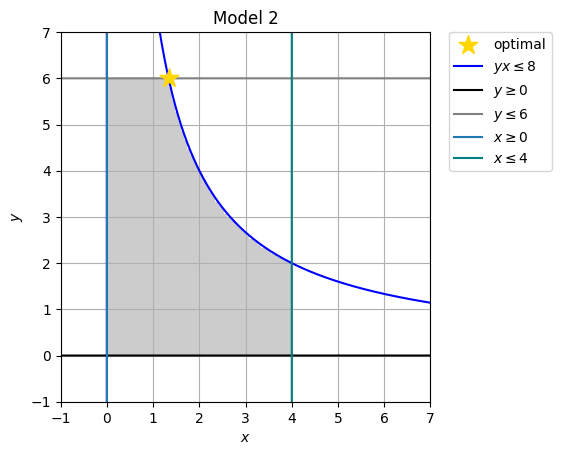

In [4]:
model2 = NonconvexOpt(b1=8,
                      y_lb=0,
                      y_ub=6,
                      x_lb=0,
                      x_ub=4)
model2.solve()
print(f"OPTIMAL SOLUTION:\n\tobj = {round(model2.obj_opt,3)}\n\tx = {round(model2.x_opt,3)}\n\ty = {round(model2.y_opt,3)}")
model2.plot("Model 2", opt_x=model2.x_opt, opt_y=model2.y_opt)

### Extensive Form

We can also build and solve this example's extensive form using these two scenarios.

In [5]:
def EF(m1, m2):
    ef = pyo.ConcreteModel()
    # add two models as blocks
    ef.add_component("m1", m1)
    ef.add_component("m2", m2)
    # aggregate objective
    ef.obj = pyo.Objective( expr = 0.5*m1.obj + 0.5*m2.obj )
    # add the first stage var - x
    x_lb = min(ef.m1.x.lb, ef.m2.x.lb)
    x_ub = min(ef.m1.x.ub, ef.m2.x.ub)
    ef.x = pyo.Var(within=pyo.Reals,
                   bounds = (x_lb, x_ub))
    # make x = x1
    @ef.Constraint()
    def nonant_x1_rule(ef):
        return (ef.x == ef.m1.x)
    # make x = x2
    @ef.Constraint()
    def nonant_x2_rule(ef):
        return (ef.x == ef.m2.x)
    return ef

def solve_ef(ef):
    ef.m1.obj.deactivate()
    ef.m2.obj.deactivate()
    opt = pyo.SolverFactory("gurobi")
    opt.options["NonConvex"] = 2
    opt.solve(ef, tee=False)

In [6]:
# build the model
ef = EF(model1.m, model2.m)

In [7]:
# solve the EF
solve_ef(ef)

In [8]:
# visualize the model
ef.display()

Model unknown

  Variables:
    x : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :   1.0 :     4 : False : False :  Reals

  Objectives:
    obj : Size=1, Index=None, Active=True
        Key  : Active : Value
        None :   True :  -6.0

  Constraints:
    nonant_x1_rule : Size=1
        Key  : Lower : Body : Upper
        None :   0.0 :  0.0 :   0.0
    nonant_x2_rule : Size=1
        Key  : Lower : Body : Upper
        None :   0.0 :  0.0 :   0.0

  Blocks:
    Block m1
    
      Variables:
        x : Size=1, Index=None
            Key  : Lower : Value : Upper : Fixed : Stale : Domain
            None :     0 :   1.0 :     6 : False : False :  Reals
        y : Size=1, Index=None
            Key  : Lower : Value : Upper : Fixed : Stale : Domain
            None :     0 :   4.0 :     4 : False : False :  Reals
    
      Objectives:
        None
    
      Constraints:
        c1_rule : Size=1
            Key  : Lower : Body

We can visualize the results of the EF. The x variables are the same across both scenarios, while we are allowed to have different y's. We solved this EF with an equal probabilistic weight (so Scenario (1) and Scenario (2) both have a probability of 1/2).

OPTIMAL SOLUTION EF:
	obj = -6.0
	x = 1.0
	y1 = 4.0
	y2 = 6.0


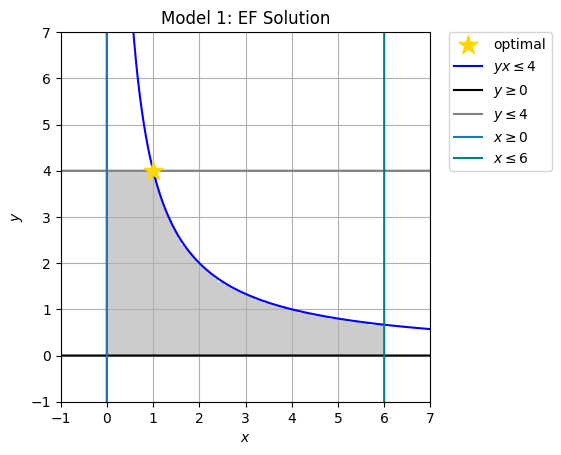

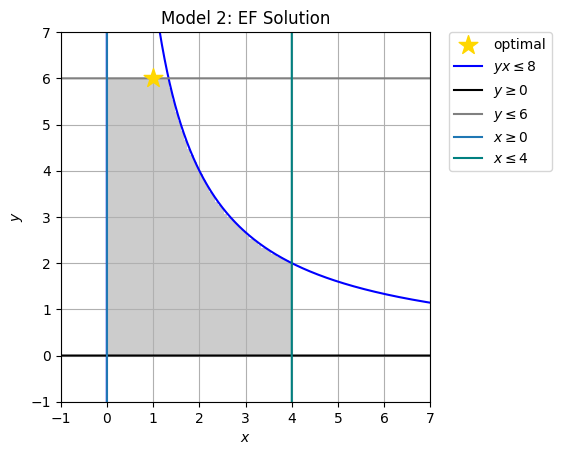

In [9]:
ef_opt_x = pyo.value(ef.x)
ef_opt_y1 = pyo.value(ef.m1.y)
ef_opt_y2 = pyo.value(ef.m2.y)
ef_opt_obj = pyo.value(ef.obj)
print(f"OPTIMAL SOLUTION EF:\n\tobj = {ef_opt_obj}\n\tx = {ef_opt_x}\n\ty1 = {ef_opt_y1}\n\ty2 = {ef_opt_y2}")
model1.plot("Model 1: EF Solution", opt_x=ef_opt_x, opt_y=ef_opt_y1)
model2.plot("Model 2: EF Solution", opt_x=ef_opt_x, opt_y=ef_opt_y2)

## SNoGlode: Structured Nonlinear Global Optimization Solver

This is a very small example case study. If we can easily solve the EF, SNoGlode is a bit of overkill but it will serve well in this case for demonstrative purposes. 

In [10]:
import snoglode as sno

In [11]:
def subproblem_creator(subproblem_name):
    if subproblem_name=="model1":
        optmodel = NonconvexOpt(b1=4,
                                y_lb=0,
                                y_ub=4,
                                x_lb=0,
                                x_ub=6)
        model = optmodel.m
    if subproblem_name=="model2":
        optmodel = NonconvexOpt(b1=8,
                                y_lb=0,
                                y_ub=6,
                                x_lb=0,
                                x_ub=4)
        model = optmodel.m
    
    lifted_variable_ids = {"x": model.x}
    subproblem_probability = 1/2

    return [model,                              # pyomo model corresponding to this subproblem
            lifted_variable_ids,                # lifted varID : pyo.Var dict
            subproblem_probability]             # probability of this subproblem

subproblem_names = ["model1", "model2"]
gurobi = pyo.SolverFactory("gurobi")
gurobi.options["NonConvex"] = 2

lb_solver = gurobi
cg_solver = gurobi
ub_solver = gurobi

SNGO is highly customizable, in how we choose to solve a lower bounding problem and how we generate candidate solutions for the upper bounding problem. First, we can solve this problem using the default lower bounder (dropping nonanticipativaty constraints and solving each of the subproblems (or scenarios) independent of one another, enforcing bounds to reflect current node of the spatial BnB tree) and the averaging candidate solution method. This candidate generation method takes the solution of all of the first stage (or lifted) variables at the current iterations solve, averages them across the scenarios, and uses the aggregated variable value for the candidate solution. 

In [12]:
params = sno.SolverParameters(subproblem_names=subproblem_names,
                              subproblem_creator=subproblem_creator,
                              lb_solver = lb_solver,
                              cg_solver = cg_solver,
                              ub_solver = ub_solver)
params.set_bounders(candidate_solution_finder = sno.AverageLowerBoundSolution)
params.display()

--------------------------------------------------
SNoGloDe Solver Parameters
--------------------------------------------------

Subproblem Names:
  - model1
  - model2
Total # subproblems: 2

LB solver: gurobi
UB solver: gurobi
CG solver: gurobi

Global convergance guaranteed: True
Epsilon: 0.001
Perform FBBT: True
Relax binaries at LB: False

Bounder Information
  - Lower Bounder: DropNonants
  - Candidate Generator: AverageLowerBoundSolution

Queuing strategy: QueueStrategy.bound
Using a node feasibility checker? : False

Branching Information
  - Selection Strategy: RandomSelection
  - Partition Strategy: Midpoint

Verbose: False
No log file generated.

--------------------------------------------------


In [13]:
solver = sno.Solver(params)
solver.solve(max_iter=50,
             collect_plot_info=True)

        Time (s)  Nodes Explored       Pruned by                              LB              UB        Rel. Gap        Abs. Gap         # Nodes
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------
           0.015               1                                      -6.1666667      -4.9166667        25.4237%            1.25               2


           0.029               2                           * U        -6.1666667      -5.8809524         4.8583%        0.285714               3


           0.037               3           Bound                      -6.1666667      -5.8809524         4.8583%        0.285714               2


           0.048               4                           * U        -6.1666667            -6.0         2.7778%        0.166667               3


           0.062               5                                      -6.1666667            -6.0         2.7778%        0.166667               4


           0.075               6                                      -6.1666667            -6.0         2.7778%        0.166667               5


           0.082               7           Bound                      -6.1666667            -6.0         2.7778%        0.166667               4


             0.1               8                                      -6.1666667            -6.0         2.7778%        0.166667               5


           0.107               9                                          -6.125            -6.0         2.0833%           0.125               4


           0.119              10                                          -6.125            -6.0         2.0833%           0.125               5


           0.126              11                                         -6.0625            -6.0         1.0417%          0.0625               4


           0.137              12                                         -6.0625            -6.0         1.0417%          0.0625               5


           0.143              13                                        -6.03125            -6.0         0.5208%         0.03125               4
SNoGloDe converged - relative gap tolerance met.


In [14]:
print("\n====================================================================")
print("SOLUTION")
print(f"Obj: {solver.tree.metrics.ub}")
for name in subproblem_names:
    print(f"subproblem = {name}")
    for var_name in solver.solution.subproblem_solutions[name]:
        var_val = solver.solution.subproblem_solutions[name][var_name]
        print(f"  var name = {var_name}, value = {var_val}")
    print()
print("====================================================================")


SOLUTION
Obj: -6.0
subproblem = model1
  var name = x, value = 1.0
  var name = y, value = 4.0

subproblem = model2
  var name = x, value = 1.0
  var name = y, value = 6.0



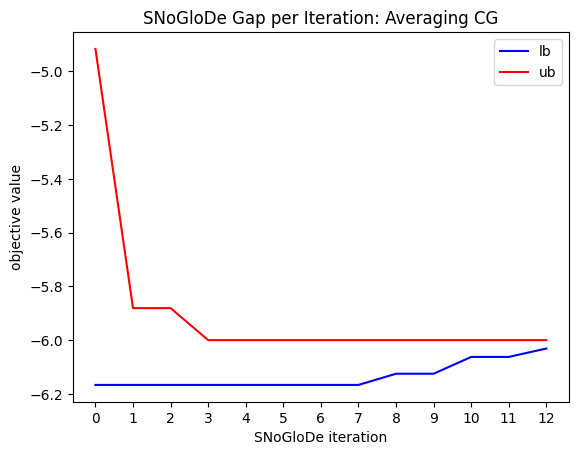

In [15]:
num_iters = np.arange(solver.iteration)
plt.plot(num_iters, solver.plotter.iter_lb, label = "lb", color="blue")
plt.plot(num_iters, solver.plotter.iter_ub, label = "ub", color="red")
plt.legend()
plt.xlabel("SNoGloDe iteration")
plt.xticks(num_iters)
plt.ylabel("objective value")
plt.title("SNoGloDe Gap per Iteration: Averaging CG");

We can see how the spatial branch and bound tree progresses over the iterations.

In [16]:
def plot(self, title, opt_x, opt_y, x_lb, x_ub):

    fig, ax = plt.subplot()

    # plot the feasible region
    d = np.linspace(-10,10,300)
    x,y = np.meshgrid(d,d)
    plt.imshow( ((y>=self.y_lb) & (y <= self.y_ub) & (x>=self.x_lb) & (x<=self.x_ub) & \
                    (y*x <= self.b1) ).astype(int) , 
                    extent=(x.min(),x.max(),y.min(),y.max()),
                    origin="lower", cmap="Greys", alpha = 0.2);
    # plot the lines defining the constraints
    x = np.linspace(-1, 7, 2000)
    # y >= 0
    y1 = 0*x + self.y_lb
    # y <= 4
    y2 = 0*x + self.y_ub
    # y <= 4/x
    y3 = self.b1 / x
    # Make plot
    plt.scatter(opt_x, opt_y, marker="*", color = "gold", s=200, zorder=100, label="optimal")
    plt.plot(x, y3, label=f'$yx\leq {self.b1}$', color="blue")
    plt.plot(x, y1, label=f'$y\geq {self.y_lb}$', color="black")
    plt.plot(x, y2, label=f'$y\leq {self.y_ub}$', color="grey")
    # bounds on x var
    plt.plot(np.linspace(self.x_lb,self.x_lb,2000), x, label=f'$x\geq {self.x_lb}$')
    plt.plot(np.linspace(self.x_ub,self.x_ub,2000), x, label=f'$x\leq {self.x_ub}$', color = "teal")
    plt.xlim(-1,7)
    plt.ylim(-1,7)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel(r'$x$')
    plt.ylabel(r'$y$')
    plt.title(title)

    # shade to indicate the spacial BnB node
    ax.axvspan(-2, x_lb, alpha=0.2, color='red')
    ax.axvspan(x_ub, 8, alpha=0.2, color='red')

    plt.grid()
    plt.show()

We can also solve this problem using the default lower bounder (dropping nonanticipativaty constraints and solving each of the subproblems (or scenarios) independent of one another, enforcing bounds to reflect current node of the spatial BnB tree) and the extensive form method for candidate generation. This method is intended to be used to solve the EF to *local* optimality, and using this as a candidate solution for the upper bounding problem. For this example, because we can solve the EF trivially, we reach the best UB in the first iteration.

In [17]:
params.set_bounders(candidate_solution_finder = sno.SolveExtensiveForm)
params.display()

--------------------------------------------------
SNoGloDe Solver Parameters
--------------------------------------------------

Subproblem Names:
  - model1
  - model2
Total # subproblems: 2

LB solver: gurobi
UB solver: gurobi
CG solver: gurobi

Global convergance guaranteed: True
Epsilon: 0.001
Perform FBBT: True
Relax binaries at LB: False

Bounder Information
  - Lower Bounder: DropNonants
  - Candidate Generator: SolveExtensiveForm

Queuing strategy: QueueStrategy.bound
Using a node feasibility checker? : False

Branching Information
  - Selection Strategy: RandomSelection
  - Partition Strategy: Midpoint

Verbose: False
No log file generated.

--------------------------------------------------


In [18]:
solver = sno.Solver(params)
solver.solve(max_iter=50,
             collect_plot_info=True)

        Time (s)  Nodes Explored       Pruned by                              LB              UB        Rel. Gap        Abs. Gap         # Nodes
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------
           0.018               1                                      -6.1666667            -6.0         2.7778%        0.166667               2


           0.036               2                                      -6.1666667            -6.0         2.7778%        0.166667               3


           0.044               3           Bound                      -6.1666667            -6.0         2.7778%        0.166667               2


           0.058               4                                      -6.1666667            -6.0         2.7778%        0.166667               3


           0.075               5                                      -6.1666667            -6.0         2.7778%        0.166667               4


           0.091               6                                      -6.1666667            -6.0         2.7778%        0.166667               5


           0.099               7           Bound                      -6.1666667            -6.0         2.7778%        0.166667               4


           0.115               8                                      -6.1666667            -6.0         2.7778%        0.166667               5


           0.123               9                                          -6.125            -6.0         2.0833%           0.125               4


           0.139              10                                          -6.125            -6.0         2.0833%           0.125               5


           0.145              11                                         -6.0625            -6.0         1.0417%          0.0625               4


            0.16              12                                         -6.0625            -6.0         1.0417%          0.0625               5


           0.167              13                                        -6.03125            -6.0         0.5208%         0.03125               4
SNoGloDe converged - relative gap tolerance met.


In [19]:
print("\n====================================================================")
print("SOLUTION")
print(f"Obj: {solver.tree.metrics.ub}")
for name in subproblem_names:
    print(f"subproblem = {name}")
    for var_name in solver.solution.subproblem_solutions[name]:
        var_val = solver.solution.subproblem_solutions[name][var_name]
        print(f"  var name = {var_name}, value = {var_val}")
    print()
print("====================================================================")


SOLUTION
Obj: -6.0
subproblem = model1
  var name = model1.x, value = 1.0
  var name = model1.y, value = 4.0

subproblem = model2
  var name = model2.x, value = 1.0
  var name = model2.y, value = 6.0



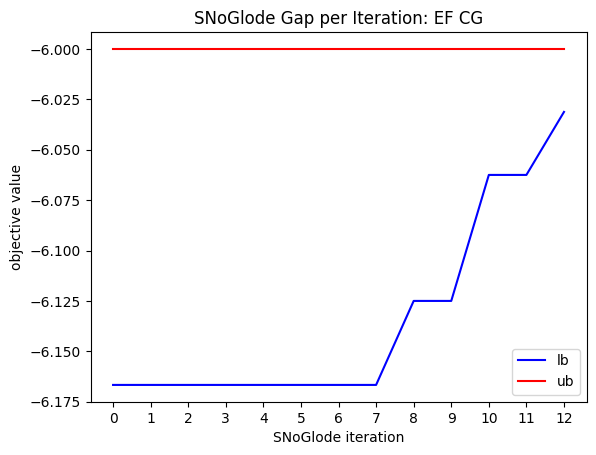

In [20]:
num_iters = np.arange(solver.iteration)
plt.plot(num_iters, solver.plotter.iter_lb, label = "lb", color="blue")
plt.plot(num_iters, solver.plotter.iter_ub, label = "ub", color="red")
plt.legend()
plt.xlabel("SNoGlode iteration")
plt.xticks(num_iters)
plt.ylabel("objective value")
plt.title("SNoGlode Gap per Iteration: EF CG");

In [21]:
import datetime
now = datetime.datetime.now()
print("Jupyter notebook last ran:", now)

Jupyter notebook last ran: 2025-02-18 14:52:40.884428
